<a href="https://colab.research.google.com/github/badlogic/genai-workshop/blob/main/01_supervised_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We use Pytorch for the actual supervised learning part, and scikit-learn to generate our training and test sets.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.optim import SGD
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

Generate a random 2D dataset with 2 classes, and split it into training and validation set.

In [2]:
# Generate a 2D dataset that is (mostly) linearly separable.
X, y = make_classification(n_samples=100, n_features=2, n_redundant=0, n_clusters_per_class=1)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

Plot the dataset

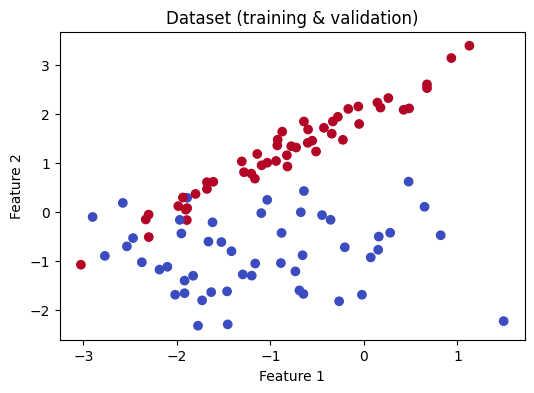

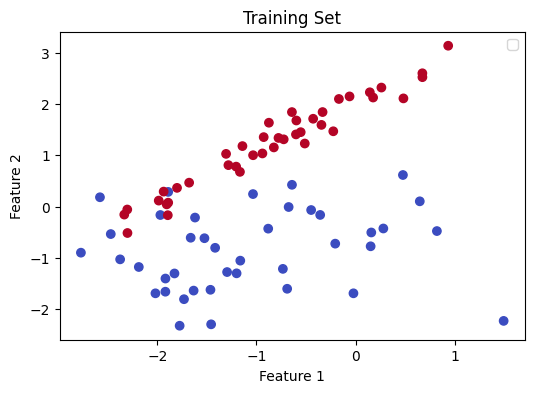

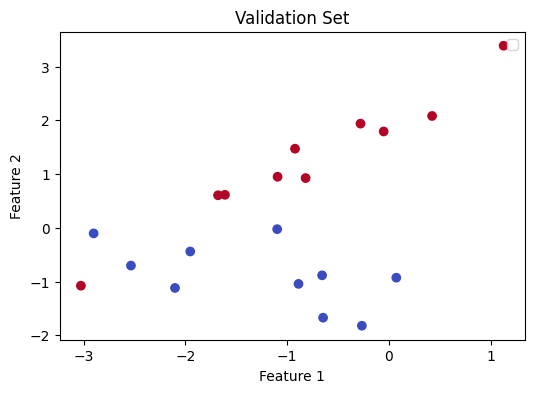

In [4]:
# Plot the full dataset
plt.figure(figsize=(6, 4))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm')
plt.title('Dataset (training & validation)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

# Plot the training set
plt.figure(figsize=(6, 4))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='coolwarm')
plt.title('Training Set')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

# Plot the validation set
plt.figure(figsize=(6, 4))
plt.scatter(X_val[:, 0], X_val[:, 1], c=y_val, cmap='coolwarm')
plt.title('Validation Set')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

Convert the dataset to Pytorch tensors and create dataloaders for them.



In [5]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

# Create dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=10, shuffle=False)

Define a simple linear neural network layer, an optimizer, and a loss function used for training.

Set up the training loop. For each epoch (number of times we show the full training set to the network), go through the training set one batch at a time (`batch_size=10`).

For each batch
* Reset the gradients in the optimizer
* Get a prediction for each training sample
* Calculate the loss by comparing the predicted labels with the actual labels
* Perform back propagation to calculate new gradients
* Use the gradients to update the weights and bias in the neural network layer

We also keep track of the average training loss for each epoch, and print it at the end of the epoch. This way we can see if the model improves (training loss should get smaller)



In [6]:
# Initialize the linear layer
linear_layer = nn.Linear(2, 2)  # 2 input features, 2 output classes
optimizer = SGD(linear_layer.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

# Training loop with loss accumulation and averaging
# Increase the number of epochs to see if it has
# a positive or negative effect on the training loss
num_epochs = 50
for epoch in range(num_epochs):
    total_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = linear_layer(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    average_loss = total_loss / len(train_loader)
    print(f'Epoch {epoch+1}, Average Training Loss: {average_loss:.4f}')

Epoch 1, Average Training Loss: 0.8637
Epoch 2, Average Training Loss: 0.8039
Epoch 3, Average Training Loss: 0.7516
Epoch 4, Average Training Loss: 0.7066
Epoch 5, Average Training Loss: 0.6675
Epoch 6, Average Training Loss: 0.6339
Epoch 7, Average Training Loss: 0.6043
Epoch 8, Average Training Loss: 0.5786
Epoch 9, Average Training Loss: 0.5558
Epoch 10, Average Training Loss: 0.5358
Epoch 11, Average Training Loss: 0.5178
Epoch 12, Average Training Loss: 0.5024
Epoch 13, Average Training Loss: 0.4877
Epoch 14, Average Training Loss: 0.4755
Epoch 15, Average Training Loss: 0.4629
Epoch 16, Average Training Loss: 0.4525
Epoch 17, Average Training Loss: 0.4425
Epoch 18, Average Training Loss: 0.4335
Epoch 19, Average Training Loss: 0.4251
Epoch 20, Average Training Loss: 0.4174
Epoch 21, Average Training Loss: 0.4107
Epoch 22, Average Training Loss: 0.4041
Epoch 23, Average Training Loss: 0.3976
Epoch 24, Average Training Loss: 0.3919
Epoch 25, Average Training Loss: 0.3865
Epoch 26,

Now we can test the model by asking it to classify samples from the validation set it has not yet seen previously. We count the number of correctly classified samples and divide that number by the total number of samples. This gives us the accuracy of the model on the validation set.

In [7]:
# Evaluation on validation set
linear_layer.eval()  # Set the model to evaluation mode
with torch.no_grad():
    inputs = X_val_tensor
    labels = y_val_tensor
    outputs = linear_layer(inputs)
    _, predicted = torch.max(outputs, 1)
    total = labels.size(0)
    correct = (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy on the validation set: {accuracy}%')

Accuracy on the validation set: 95.0%


Let's visualize what the model learned, and why it's not 100% accurate. Since this is a single layer linear neural network, we can easily interpret its weights and bias as a 2D line, also known as the decision boundary.

When the model makes a prediction for a sample, it essentially checks if the point is above or below the line, and assigns the corresponding class for the respective side.

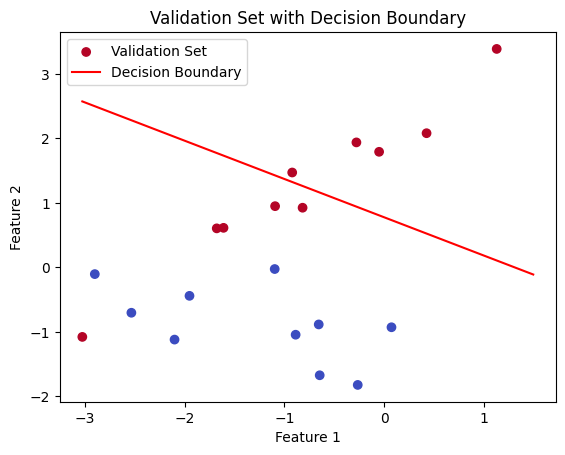

In [8]:
# Plot the validation set and the model's decision boundary
plt.scatter(X_val[:, 0], X_val[:, 1], c=y_val, cmap='coolwarm', label='Validation Set')

# Calculate the decision boundary
weights = linear_layer.weight.data.numpy()
bias = linear_layer.bias.data.numpy()
x_boundary = np.array([X[:,0].min(), X[:,0].max()])
y_boundary = -(bias[0] + weights[0][0]*x_boundary) / weights[0][1]

plt.plot(x_boundary, y_boundary, '-r', label='Decision Boundary')
plt.title('Validation Set with Decision Boundary')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()